# Example of computing vibrational energy levels of ammonia (NH3)

The Taylor series expansions of the KEO and PES are generated in [nh3_keo_beta.ipynb](nh3_keo_beta.ipynb) and [nh3_pes_beta.ipynb](nh3_pes_beta.ipynb), respectively.

In [1]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp
from numpy.polynomial.hermite import hermgauss

from vibrojet.basis_utils import ContrBasis, HermiteBasis

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

config.update("jax_enable_x64", True)

Read KEO and PES expansion coefficients.

In [2]:
max_order_keo = 8
max_order_pes = 8

gmat_file = f"_nh3_gmat_beta_y_coefs_{max_order_keo}.npz"
data = np.load(gmat_file)
gmat_coefs = data["coefs"]
gmat_terms = data["ind"]
keo_q0 = data["q0"]
keo_y0 = data["y0"]

pseudo_file = f"_nh3_pseudo_beta_y_coefs_{max_order_keo}.npz"
data = np.load(pseudo_file)
pseudo_coefs = data["coefs"]
pseudo_terms = data["ind"]

pes_file = f"_nh3_poten_beta_y_coefs_{max_order_pes}.npz"
data = np.load(pes_file)
pes_coefs = data["coefs"]
pes_terms = data["ind"]
pes_y0 = data["q0"]

# ! TODO: need to store q0 and a_morse for PES in files
pes_q0 = np.array(
    [
        1.01159999e00,
        1.01159999e00,
        1.01159999e00,
        6.95820540e-09,
        2.12731136e-09,
        3.85722364e-01,
    ]
)
a_morse = 2.0
ncoo = len(pes_q0)

assert all(
    np.abs(pes_q0[:-1] - keo_q0[:-1]) < 1e-8
), f"Reference internal coordinates 1..5 for KEO and PES must be equal"

q0 = [q for q in pes_q0]

Define transformation from the internal coordinates to the coordinates used for Taylor series expansions of KEO and PES in [nh3_keo_beta.ipynb](nh3_keo_beta.ipynb) and [nh3_pes_beta.ipynb](nh3_pes_beta.ipynb).

In [3]:
def keo_coords(q, q0, icoo):
    if icoo in (0, 1, 2):
        return q - q0
    elif icoo in (3, 4):
        return q
    elif icoo == 5:
        rho = q + jnp.pi / 2
        return jnp.cos(rho)
    else:
        raise ValueError(f"'icoo' = {icoo} > 5")


def pes_coords(q, q0, icoo, a_morse):
    if icoo in (0, 1, 2):
        return 1.0 - jnp.exp(-a_morse * (q - q0))
    elif icoo in (3, 4):
        return q
    elif icoo == 5:
        rho = q + jnp.pi / 2
        return jnp.sin(rho)
    else:
        raise ValueError(f"'icoo' = {icoo} > 5")

Define linear mapping between coordinates of Hermite functions and internal coordinates.

In [4]:
# G-matrix at equilibrium

mask = gmat_terms != 0
ind0 = np.where(mask.sum(axis=1) == 0)[0][0]
mu = np.diag(gmat_coefs[ind0])[: len(q0)]

# first and second derivative of potential wrt internal coordinates

mask = pes_terms != 0
ind1 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (pes_terms[:, icoo] == 1))[0][0]
        for icoo in range(len(q0))
    ]
)
ind2 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (pes_terms[:, icoo] == 2))[0][0]
        for icoo in range(len(q0))
    ]
)
dv_dy = pes_coefs[ind1]
d2v_dy2 = pes_coefs[ind2] * 2

grad = jax.grad(pes_coords)
hess = jax.grad(grad)
dy_dq = np.array([grad(pes_y0[icoo], q0[icoo], icoo, a_morse) for icoo in range(ncoo)])
d2y_dq2 = np.array(
    [hess(pes_y0[icoo], q0[icoo], icoo, a_morse) for icoo in range(ncoo)]
)

freq = d2v_dy2 * (dy_dq) ** 2 + dv_dy * d2y_dq2

# linear transformation between harmonic-oscillator coordinate (x)
# and internal coordinates (q)

lin_a = np.sqrt(np.sqrt(mu / freq))
lin_b = q0
lin_b[-1] = 0  # set center at the planar geometry

print("x->q linear mapping parameters 'a':\n", lin_a)
print("x->q linear mapping parameters 'b':\n", lin_b)

# # x->q linear mapping function
x_to_q = lambda x, icoo: lin_a[icoo] * x + lin_b[icoo]

x->q linear mapping parameters 'a':
 [0.03639106 0.03639106 0.03639106 0.27051765 0.27051765 0.07510423]
x->q linear mapping parameters 'b':
 [np.float64(1.01159999), np.float64(1.01159999), np.float64(1.01159999), np.float64(6.9582054e-09), np.float64(2.12731136e-09), 0]


Plot 1D cuts of PES along different internal coordinates.

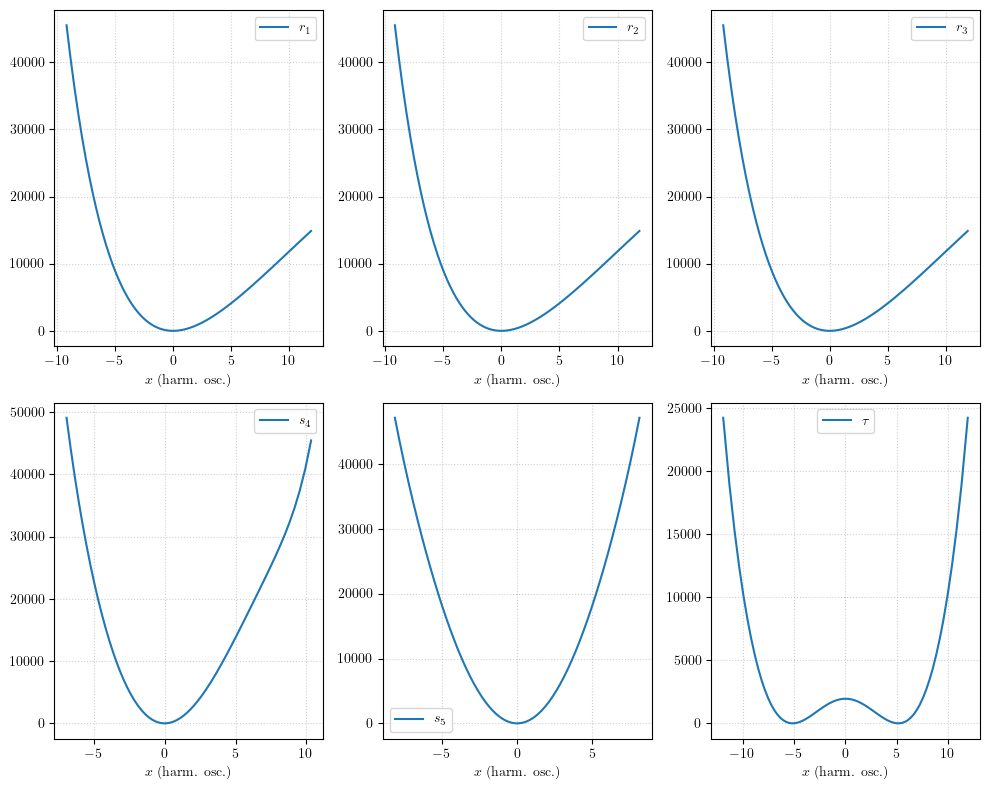

In [5]:
# function computes potential at points
poten_taylor = jax.vmap(
    lambda y: jnp.sum(
        pes_coefs * jnp.prod((y - pes_y0)[None, :] ** pes_terms, axis=-1)
    ),
    in_axes=0,
)

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=100)
coo_label = ("$r_1$", "$r_2$", "$r_3$", "$s_4$", "$s_5$", "$\\tau$")

for icoo, ax in enumerate(axes.flat):
    x, w = hermgauss(80)
    q = x_to_q(x, icoo)
    y = pes_coords(q, q0[icoo], icoo, a_morse)

    if icoo > 2:
        q = q * 180 / np.pi

    y_6d = np.ones((len(y), 6)) * np.array(pes_y0)[None, :]
    y_6d[:, icoo] = y

    v = poten_taylor(y_6d)
    v = np.array(v)
    v[v > 50000] = None

    ax.plot(x, v, label=f"{coo_label[icoo]}")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q, v, label=f"{icoo}")
    # ax.set_xlabel("$q$")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Plot 1D cuts of different elements of $G$-matrix along the inversion coordinate $\tau$.

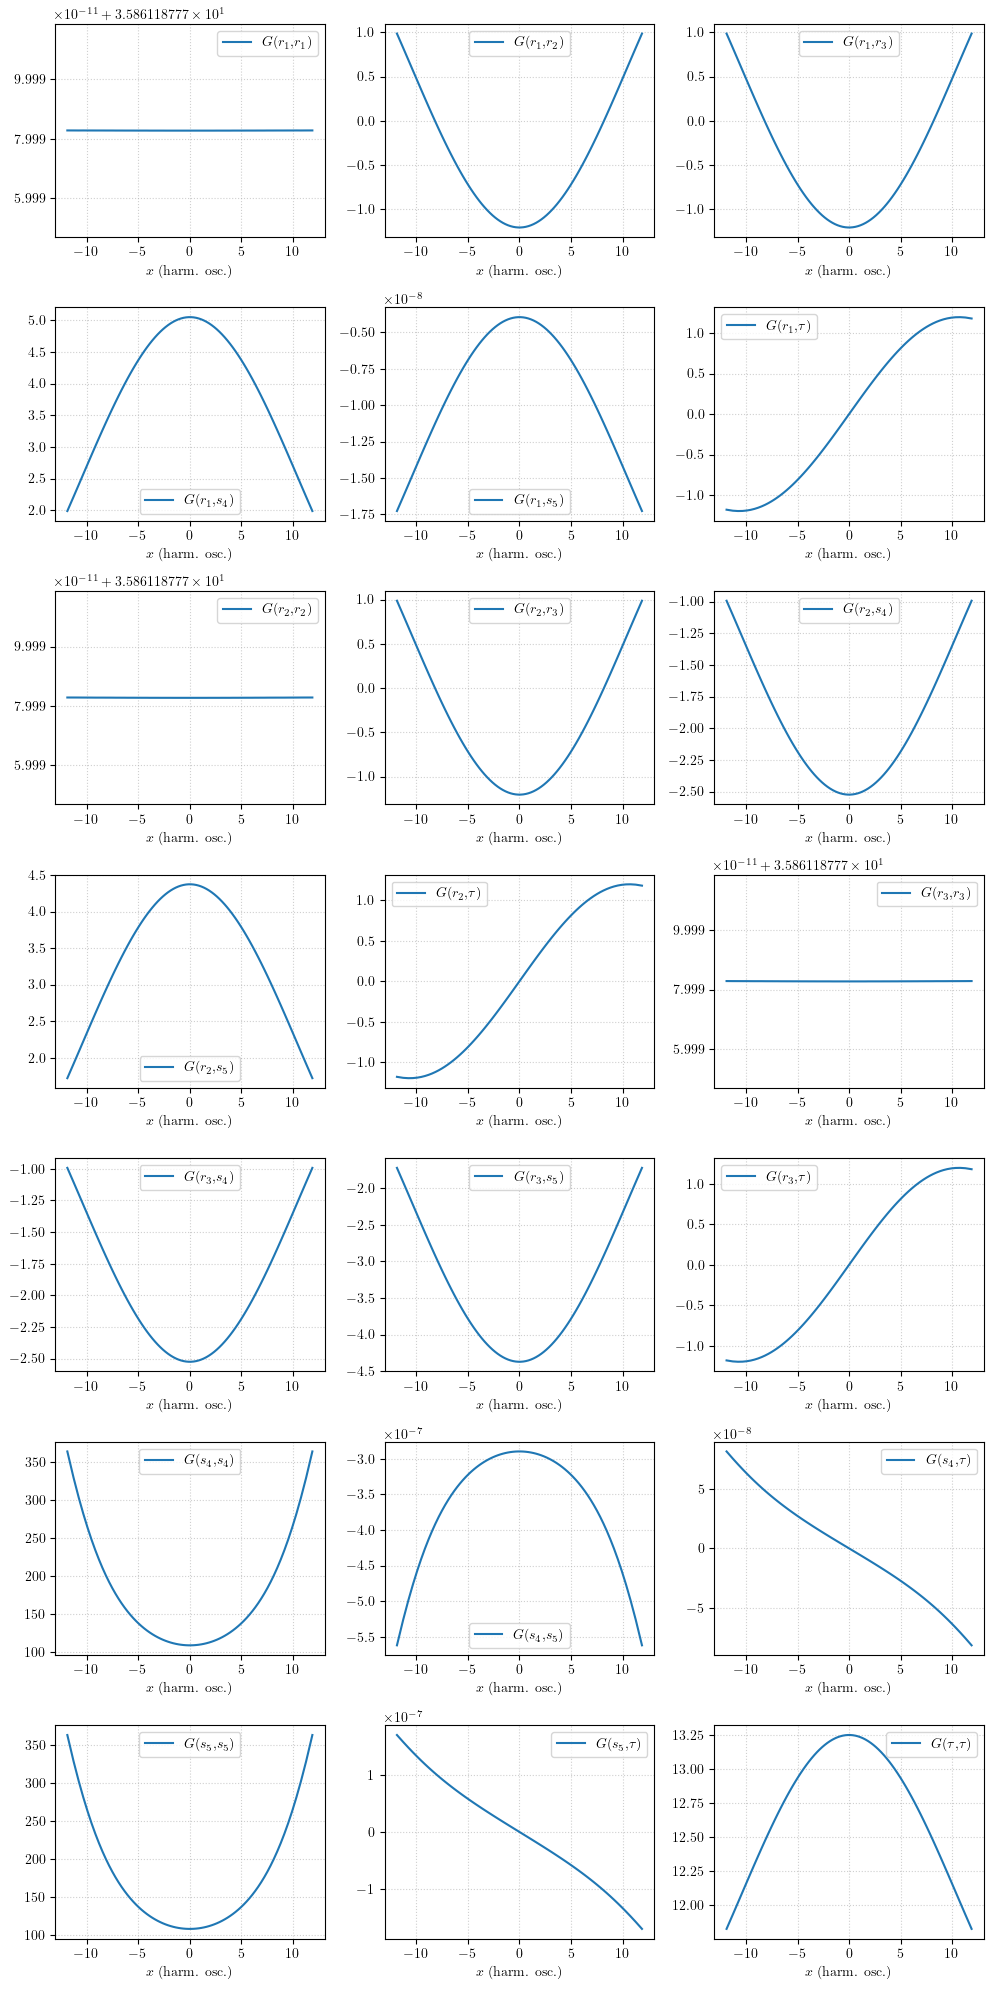

In [6]:
# function computes G-matrix at points
gmat_taylor = jax.vmap(
    lambda y: gmat_coefs.swapaxes(0, 2)
    @ jnp.prod((y - keo_y0)[None, :] ** gmat_terms, axis=-1),
    in_axes=0,
)

fig, axes = plt.subplots(7, 3, figsize=(10, 20), dpi=100)

x, w = hermgauss(80)
icoo = 5
q = x_to_q(x, icoo)
y = keo_coords(q, keo_q0[icoo], icoo)
q_deg = q * 180 / np.pi
y_6d = np.ones((len(y), 6)) * np.array(keo_y0)[None, :]
y_6d[:, icoo] = y
gmat = gmat_taylor(y_6d)

gmat = [((i, j), gmat[:, i, j]) for i in range(6) for j in range(i, 6)]
coo_label = ("$r_1$", "$r_2$", "$r_3$", "$s_4$", "$s_5$", "$\\tau$")

for ((icoo, jcoo), g), ax in zip(gmat, axes.flat):
    ax.plot(x, g, label=f"$G$({coo_label[icoo]},{coo_label[jcoo]})")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q_deg, g, label=f"$G$({coo_label[icoo]},{coo_label[jcoo]})")
    # ax.set_xlabel("$\\tau$ (deg.)")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Plot 1D cuts of pseudopotential along different internal coordinates.

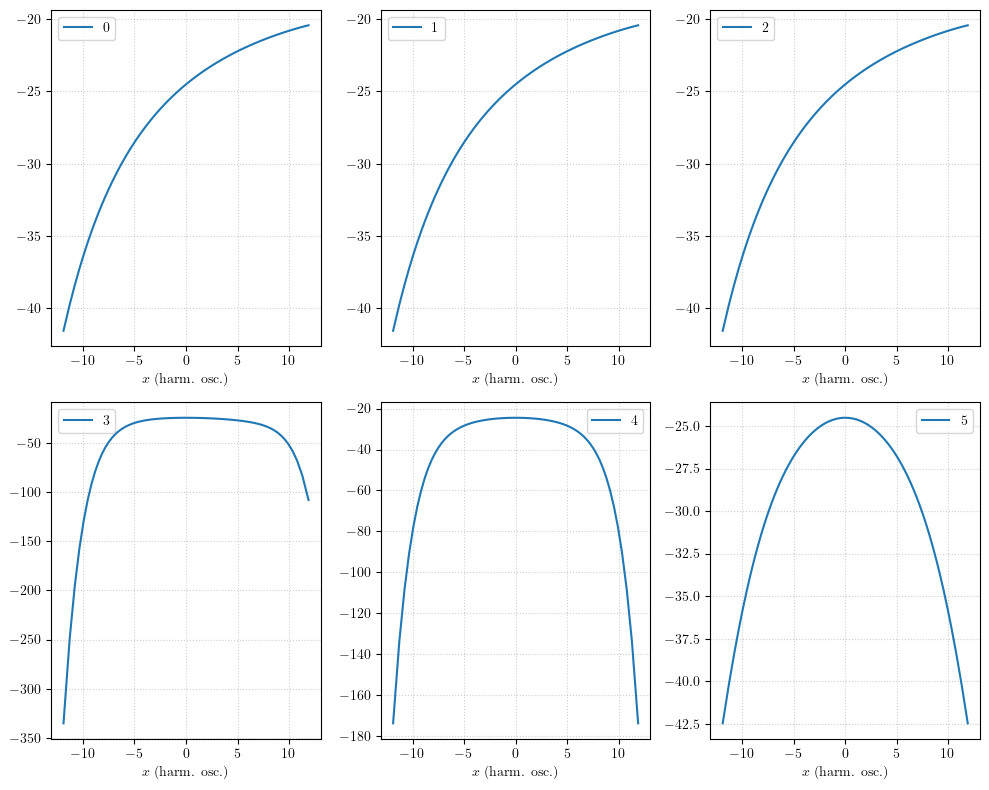

In [7]:
# function computes pseudopotential at points
pseudo_taylor = jax.vmap(
    lambda y: jnp.sum(
        pseudo_coefs * jnp.prod((y - keo_y0)[None, :] ** pseudo_terms, axis=-1)
    ),
    in_axes=0,
)

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=100)

for icoo, ax in enumerate(axes.flat):
    x, w = hermgauss(80)
    q = x_to_q(x, icoo)
    y = keo_coords(q, keo_q0[icoo], icoo)

    if icoo > 2:
        q = q * 180 / np.pi

    y_6d = np.ones((len(y), 6)) * np.array(keo_y0)[None, :]
    y_6d[:, icoo] = y

    v = pseudo_taylor(y_6d)

    ax.plot(x, v, label=f"{icoo}")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q, v, label=f"{icoo}")
    # ax.set_xlabel("$q$")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Generate primitive Hermite basis sets.

In [8]:
nbas = [60] * ncoo
npoints = [80] * ncoo

p_r1, p_r2, p_r3, p_s4, p_s5, p_tau = [
    HermiteBasis(
        icoo,
        nbas[icoo],
        npoints[icoo],
        lambda x: x_to_q(x, icoo),
        lambda q: keo_coords(q, keo_q0[icoo], icoo) - keo_y0[icoo],
        lambda q: pes_coords(q, pes_q0[icoo], icoo, a_morse) - pes_y0[icoo],
        gmat_terms[:, icoo],
        pes_terms[:, icoo],
        pseudo_terms[:, icoo],
    )
    for icoo in range(ncoo)
]

Compute 1D contracted basis sets, by solving 1D reduced-mode Schrödinger equations for each coordinate.

In [9]:
c_r1, c_r2, c_r3, c_s4, c_s5, c_tau = [
    ContrBasis(
        (icoo,),
        [p_r1, p_r2, p_r3, p_s4, p_s5, p_tau],
        lambda _: True,
        gmat_terms,
        gmat_coefs,
        pes_terms,
        pes_coefs,
        pseudo_terms,
        pseudo_coefs,
        emax=40000,
    )
    for icoo in range(ncoo)
]

e = c_r1.enr
print("Solutions for r1 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r2.enr
print("\nSolutions for r2 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r3.enr
print("\nSolutions for r3 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_s4.enr
print("\nSolutions for alpha1 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_s5.enr
print("\nSolutions for alpha2 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_tau.enr
print("\nSolutions for tau coordinate:\n", f"zpe = {e[0]}\n", e - e[0])

Solutions for r1 coordinate:
 zpe = 4729.6218426322985
 [    0.          3635.30570969  7148.32077375 10627.71129332
 14310.53393488 18415.65420239 23002.80171988 28027.97463663
 33493.02537863 39287.26200974]

Solutions for r2 coordinate:
 zpe = 4729.621829697787
 [    0.          3635.30571153  7148.32077555 10627.711285
 14310.53389795 18415.65412491 23002.80159874 28027.97447059
 33493.02516802 39287.26175224]

Solutions for r3 coordinate:
 zpe = 4729.621853629293
 [    0.          3635.30571226  7148.32078009 10627.71131047
 14310.53397596 18415.65427608 23002.80182875 28027.9747819
 33493.02556048 39287.26222999]

Solutions for alpha1 coordinate:
 zpe = 3395.7174851824625
 [    0.          1553.39470133  3097.79760552  4632.65928187
  6157.37416537  7671.2713207   9173.6028825  10663.52938207
 12140.10081903 13602.23178488 15048.66805092 16477.94052361
 17888.29980493 19277.61961311 20643.24734118 21981.75818405
 23288.51534218 24556.78050907 25775.51128151 26921.58996311
 27920.

Compute 3D contracted basis sets for the stretching coordinates $r_1$, $r_2$, and $r_3$ by solving 3D reduced-mode Schrödinger equation, where basis functions for the bending $s_4$, $s_5$ and inversion $\tau$ coordinates are fixed to their ground (zero-order function) states.

In [10]:
c_r1_r2_r3 = ContrBasis(
    (0, 1, 2),
    [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=30000,
)

e = c_r1_r2_r3.enr
print(len(e))
print("Solutions for r1+r2+r3 coordinates:\n", f"zpe = {e[0]}\n", e - e[0])

157
Solutions for r1+r2+r3 coordinates:
 zpe = 6287.119355255309
 [    0.          3353.57074062  3480.74149778  3481.29596124
  6657.91636858  6750.42792864  6750.95747955  6898.55565397
  6939.31835766  6939.33395038  9954.58645348 10058.52768602
 10059.00742392 10193.42851224 10193.5099506  10197.09345153
 10316.92715399 10317.90910676 10334.4086865  10392.06327549
 13248.36495349 13376.45507414 13376.8469937  13524.75450694
 13524.90523085 13580.8266889  13640.46995702 13660.48132419
 13719.44925703 13719.45154677 13771.08491667 13771.17483804
 13933.45307843 13933.6422138  13934.42957528 16543.08053313
 16695.24268463 16695.56690883 16862.59504584 16893.67597047
 16894.0551432  17009.34838524 17046.65308098 17047.5327898
 17095.69898152 17158.01233409 17158.24081311 17332.72669292
 17333.24847581 17335.65596731 17394.93351846 17395.01258599
 17404.65453859 18112.33109768 18112.37459143 18112.89185228
 19849.237355   20059.1478712  20059.49012343 20212.93581118
 20284.61369222 2028

Compute 2D contracted basis sets for the bending coordinates $s_4$ and $s_5$ by solving 2D reduced-mode Schrödinger equation, where basis functions for the stretching $r_1$, $r_2$, $r_3$ and inversion $\tau$ coordinates are fixed to their ground (zero-order function) states.

In [11]:
c_s4_s5 = ContrBasis(
    (3, 4),
    [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=30000,
)

e = c_s4_s5.enr
print(len(e))
print("Solutions for s4+s5 coordinates:\n", f"zpe = {e[0]}\n", e - e[0])

185
Solutions for s4+s5 coordinates:
 zpe = 4617.064583092789
 [    0.          1686.22061008  1686.22061349  3354.02533346
  3376.9948595   3376.99485951  5025.6531398   5025.65314645
  5072.43538664  5072.63865567  6677.35914294  6701.2914684
  6701.29146842  6773.05803492  6773.05803495  8332.27037764
  8332.27038728  8380.90471302  8381.33373726  8478.76363236
  8478.76363236  9965.59697588  9990.52739361  9990.52739372
 10065.30188438 10065.30188446 10189.85491069 10189.8578004
 11601.36866706 11601.36867958 11652.22047612 11652.27924881
 11753.99054168 11753.9905418  11906.53302197 11906.53302205
 13213.68823612 13239.64658119 13239.64659484 13317.5330048
 13317.53303024 13447.30968764 13447.33294232 13628.98418512
 13628.98418513 14827.47729104 14827.47789474 14879.04845798
 14881.87937082 14986.43873042 14986.43876759 15145.4070881
 15145.40712758 15357.39250403 15357.39253071 16415.64660976
 16442.60355963 16442.60540626 16523.88674305 16523.89028936
 16658.9143804  16659.0652

Compute full-dimensional solutions using contracted basis sets for all coordinates.
The size of the total basis set is controlled by the sum of energies of the corresponding contracted basis set functions in `select_quanta`

In [12]:
e_max = 14000

e123 = np.copy(c_r1_r2_r3.enr - c_r1_r2_r3.enr[0])
e45 = np.copy(c_s4_s5.enr - c_s4_s5.enr[0])
e6 = np.copy(c_tau.enr - c_tau.enr[0])


def select_quanta(ind):
    i123, i45, i6 = ind
    cond = e123[i123] + e45[i45] + e6[i6] <= e_max
    return cond


sol = ContrBasis(
    (0, 1, 2),
    [c_r1_r2_r3, c_s4_s5, c_tau],
    select_quanta,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
    store_me=False,
)

e = sol.enr
print(len(e))
print("Solutions:\n", f"zpe = {e[0]}\n", e[:10] - e[0])

2013
Solutions:
 zpe = 7429.894880834534
 [0.00000000e+00 7.63635889e-01 9.34920835e+02 9.69556454e+02
 1.60248690e+03 1.62578524e+03 1.62578526e+03 1.62683231e+03
 1.62683232e+03 1.88376136e+03]


---------

Repeat the above multi-step contracted-basis calculations for different truncation orders in the $N$-mode expansions of KEO and PES.

In [8]:
nmode_list = list(
    set(
        [
            (n, 6, 6) if i == 0 else (6, n, 6) if i == 1 else (6, 6, n)
            for i in range(3)
            for n in range(1, 7)
        ]
    )
)

nmode_enr = {}

for nmode_gmat, nmode_pes, nmode_pseudo in nmode_list:
    print(
        f"\nRun for N-mode G-matrix/potential/pseudopotential = {nmode_gmat}/{nmode_pes}/{nmode_pseudo} ..."
    )
    ind = np.where(np.count_nonzero(gmat_terms, axis=1) <= nmode_gmat)[0]
    gmat_terms_nmode = gmat_terms[ind]
    gmat_coefs_nmode = gmat_coefs[ind]

    ind = np.where(np.count_nonzero(pes_terms, axis=1) <= nmode_pes)[0]
    pes_terms_nmode = pes_terms[ind]
    pes_coefs_nmode = pes_coefs[ind]

    ind = np.where(np.count_nonzero(pseudo_terms, axis=1) <= nmode_pseudo)[0]
    pseudo_terms_nmode = pseudo_terms[ind]
    pseudo_coefs_nmode = pseudo_coefs[ind]

    nbas = [60] * ncoo
    npoints = [80] * ncoo

    p_r1, p_r2, p_r3, p_s4, p_s5, p_tau = [
        HermiteBasis(
            icoo,
            nbas[icoo],
            npoints[icoo],
            lambda x: x_to_q(x, icoo),
            lambda q: keo_coords(q, keo_q0[icoo], icoo) - keo_y0[icoo],
            lambda q: pes_coords(q, pes_q0[icoo], icoo, a_morse) - pes_y0[icoo],
            gmat_terms_nmode[:, icoo],
            pes_terms_nmode[:, icoo],
            pseudo_terms_nmode[:, icoo],
        )
        for icoo in range(ncoo)
    ]

    c_r1, c_r2, c_r3, c_s4, c_s5, c_tau = [
        ContrBasis(
            (icoo,),
            [p_r1, p_r2, p_r3, p_s4, p_s5, p_tau],
            lambda _: True,
            gmat_terms_nmode,
            gmat_coefs_nmode,
            pes_terms_nmode,
            pes_coefs_nmode,
            pseudo_terms_nmode,
            pseudo_coefs_nmode,
            emax=40000,
        )
        for icoo in range(ncoo)
    ]

    c_r1_r2_r3 = ContrBasis(
        (0, 1, 2),
        [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        pes_terms_nmode,
        pes_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=30000,
    )

    c_s4_s5 = ContrBasis(
        (3, 4),
        [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        pes_terms_nmode,
        pes_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=30000,
    )

    e_max = 12000

    e123 = np.copy(c_r1_r2_r3.enr - c_r1_r2_r3.enr[0])
    e45 = np.copy(c_s4_s5.enr - c_s4_s5.enr[0])
    e6 = np.copy(c_tau.enr - c_tau.enr[0])


    def select_quanta(ind):
        i123, i45, i6 = ind
        cond = e123[i123] + e45[i45] + e6[i6] <= e_max
        return cond


    sol = ContrBasis(
        (0, 1, 2),
        [c_r1_r2_r3, c_s4_s5, c_tau],
        select_quanta,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        pes_terms_nmode,
        pes_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
        store_me=False,
    )

    e = sol.enr - sol.enr[0]
    print(e[:10])
    nmode_enr[(nmode_gmat, nmode_pes, nmode_pseudo)] = e[:101]


Run for N-mode G-matrix/potential/pseudopotential = 4/6/6 ...
[0.00000000e+00 7.66911825e-01 9.35143217e+02 9.69868270e+02
 1.60291431e+03 1.62635197e+03 1.62635198e+03 1.62741104e+03
 1.62741105e+03 1.88461575e+03]

Run for N-mode G-matrix/potential/pseudopotential = 6/6/6 ...
[0.00000000e+00 7.66912040e-01 9.35143232e+02 9.69868293e+02
 1.60291432e+03 1.62635197e+03 1.62635201e+03 1.62741104e+03
 1.62741108e+03 1.88461581e+03]

Run for N-mode G-matrix/potential/pseudopotential = 6/1/6 ...
[   0.            1.96474164  881.06175389  953.57466463 1514.21956312
 1623.86193278 1627.48616568 1628.48722327 1632.13382103 1888.19184495]

Run for N-mode G-matrix/potential/pseudopotential = 6/3/6 ...
[0.00000000e+00 7.66549781e-01 9.35197888e+02 9.69910202e+02
 1.60301652e+03 1.62638242e+03 1.62639592e+03 1.62744048e+03
 1.62745401e+03 1.88468592e+03]

Run for N-mode G-matrix/potential/pseudopotential = 6/4/6 ...
[0.00000000e+00 7.66903004e-01 9.35142891e+02 9.69867491e+02
 1.60291429e+03 1.6

Store resulting vibrational energies in file.

In [9]:
np.savez("_nh3_nmode_enr.npz", **{str(key): val for key, val in nmode_enr.items()})

Read vibrational energies calculated for different truncation orders in the $N$-mode expansions of KEO and PES and generate convergence plots.

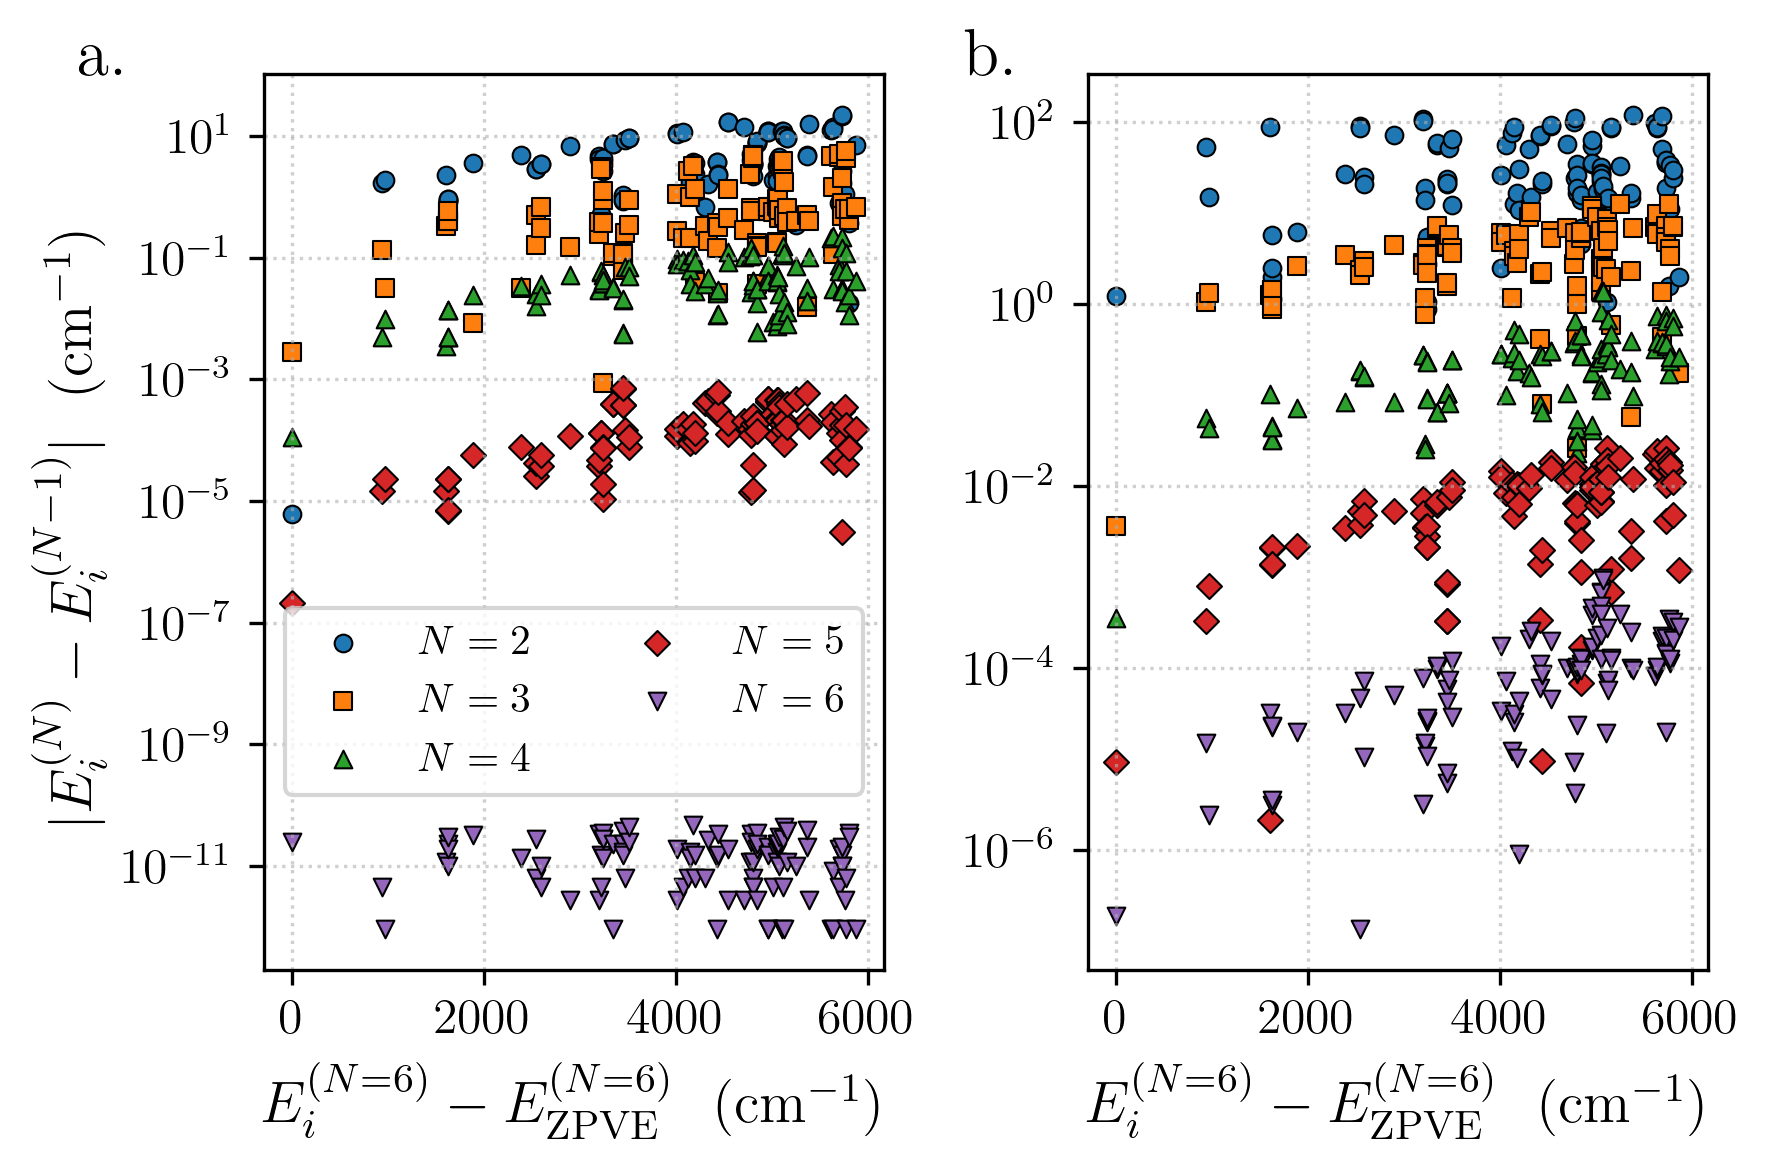

In [10]:
data = np.load("_nh3_nmode_enr.npz")
enr = {eval(key): data[key] for key in data.files}

de_gmat = np.array([np.abs(enr[(n, 6, 6)] - enr[(n - 1, 6, 6)]) for n in range(2, 7)])
de_poten = np.array([np.abs(enr[(6, n, 6)] - enr[(6, n - 1, 6)]) for n in range(2, 7)])
# label = [n for n in range(2, 7)]

fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=300)
for i, (ax, de) in enumerate(zip(axes, (de_gmat, de_poten))):
    for n, (d, marker) in enumerate(zip(de, ("o", "s", "^", "D", "v"))):
        ax.scatter(
            enr[(6, 6, 6)][1:], # skip zpe
            d[1:],
            marker=marker,
            s=18,
            edgecolors="black",
            linewidths=0.5,
            label=f"$N={n+2}$",
        )

    ax.set_yscale("log")
    ax.set_xlabel("$E_i^{(N=6)}-E_{\\rm ZPVE}^{(N=6)}$~~(${\\rm cm}^{-1}$)", fontsize=14)
    if i == 0:
        ax.set_ylabel("$|E_i^{(N)}-E_i^{(N-1)}|$~~(${\\rm cm}^{-1})$", fontsize=14)
        ax.legend(
            fontsize=10,
            ncol=2,
            loc="center",
            bbox_to_anchor=(0.5, 0.3),
        )
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=12)

# Add panel labels
axes[0].text(
    -0.3,
    1.05,
    "a.",
    transform=axes[0].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)

axes[1].text(
    -0.2,
    1.05,
    "b.",
    transform=axes[1].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)
plt.tight_layout()
fig.savefig(f"_nh3_nmode_enr.pdf", format="pdf", bbox_inches="tight")

---------

Repeat the above multi-step contracted-basis calculations for different truncation orders in the Taylor series expansions of KEO and PES.

In [23]:
pow_list = list(
    set([(n, 8) if i == 0 else (8, n) for i in range(2) for n in range(2, 9, 2)])
)

pow_enr = {}

for pow_gmat, pow_pes in pow_list:
    pow_pseudo = pow_gmat
    print(
        f"\nRun for max expansion power of G-matrix/potential/pseudopotential = {pow_gmat}/{pow_pes}/{pow_pseudo} ..."
    )
    ind = np.where(np.sum(gmat_terms, axis=1) <= pow_gmat)[0]
    gmat_terms_pow = gmat_terms[ind]
    gmat_coefs_pow = gmat_coefs[ind]

    ind = np.where(np.sum(pes_terms, axis=1) <= pow_pes)[0]
    pes_terms_pow = pes_terms[ind]
    pes_coefs_pow = pes_coefs[ind]

    ind = np.where(np.sum(pseudo_terms, axis=1) <= pow_pseudo)[0]
    pseudo_terms_pow = pseudo_terms[ind]
    pseudo_coefs_pow = pseudo_coefs[ind]

    nbas = [60] * ncoo
    npoints = [80] * ncoo

    p_r1, p_r2, p_r3, p_s4, p_s5, p_tau = [
        HermiteBasis(
            icoo,
            nbas[icoo],
            npoints[icoo],
            lambda x: x_to_q(x, icoo),
            lambda q: keo_coords(q, keo_q0[icoo], icoo) - keo_y0[icoo],
            lambda q: pes_coords(q, pes_q0[icoo], icoo, a_morse) - pes_y0[icoo],
            gmat_terms_pow[:, icoo],
            pes_terms_pow[:, icoo],
            pseudo_terms_pow[:, icoo],
        )
        for icoo in range(ncoo)
    ]

    c_r1, c_r2, c_r3, c_s4, c_s5, c_tau = [
        ContrBasis(
            (icoo,),
            [p_r1, p_r2, p_r3, p_s4, p_s5, p_tau],
            lambda _: True,
            gmat_terms_pow,
            gmat_coefs_pow,
            pes_terms_pow,
            pes_coefs_pow,
            pseudo_terms_pow,
            pseudo_coefs_pow,
            emax=40000,
        )
        for icoo in range(ncoo)
    ]

    c_r1_r2_r3 = ContrBasis(
        (0, 1, 2),
        [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
        lambda _: True,
        gmat_terms_pow,
        gmat_coefs_pow,
        pes_terms_pow,
        pes_coefs_pow,
        pseudo_terms_pow,
        pseudo_coefs_pow,
        emax=30000,
    )

    c_s4_s5 = ContrBasis(
        (3, 4),
        [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
        lambda _: True,
        gmat_terms_pow,
        gmat_coefs_pow,
        pes_terms_pow,
        pes_coefs_pow,
        pseudo_terms_pow,
        pseudo_coefs_pow,
        emax=30000,
    )

    e_max = 12000

    e123 = np.copy(c_r1_r2_r3.enr - c_r1_r2_r3.enr[0])
    e45 = np.copy(c_s4_s5.enr - c_s4_s5.enr[0])
    e6 = np.copy(c_tau.enr - c_tau.enr[0])


    def select_quanta(ind):
        i123, i45, i6 = ind
        cond = e123[i123] + e45[i45] + e6[i6] <= e_max
        return cond


    sol = ContrBasis(
        (0, 1, 2),
        [c_r1_r2_r3, c_s4_s5, c_tau],
        select_quanta,
        gmat_terms_pow,
        gmat_coefs_pow,
        pes_terms_pow,
        pes_coefs_pow,
        pseudo_terms_pow,
        pseudo_coefs_pow,
        emax=20000,
        store_me=False,
    )

    e = sol.enr - sol.enr[0]
    print(e[:10])
    pow_enr[(pow_gmat, pow_pes, pow_pseudo)] = e[:101]


Run for max expansion power of G-matrix/potential/pseudopotential = 8/8/8 ...
[0.00000000e+00 7.66912040e-01 9.35143232e+02 9.69868293e+02
 1.60291432e+03 1.62635197e+03 1.62635201e+03 1.62741104e+03
 1.62741108e+03 1.88461581e+03]

Run for max expansion power of G-matrix/potential/pseudopotential = 8/4/8 ...
[0.00000000e+00 8.03034205e-01 9.31057197e+02 9.67526813e+02
 1.59288248e+03 1.62657794e+03 1.62657798e+03 1.62770058e+03
 1.62770062e+03 1.88112490e+03]

Run for max expansion power of G-matrix/potential/pseudopotential = 6/8/6 ...
[0.00000000e+00 7.64178546e-01 9.34953179e+02 9.69550461e+02
 1.60276939e+03 1.62578037e+03 1.62578041e+03 1.62683269e+03
 1.62683272e+03 1.88391550e+03]

Run for max expansion power of G-matrix/potential/pseudopotential = 4/8/4 ...
[0.00000000e+00 7.50692686e-01 9.34872764e+02 9.68943279e+02
 1.60322979e+03 1.62241268e+03 1.62241271e+03 1.62343027e+03
 1.62343030e+03 1.88236247e+03]

Run for max expansion power of G-matrix/potential/pseudopotential =

Store resulting vibrational energies in file.

In [24]:
np.savez("_nh3_pow_enr.npz", **{str(key): val for key, val in pow_enr.items()})

Read vibrational energies calculated for different truncation orders in the Taylor expansions of KEO and PES and generate convergence plots.

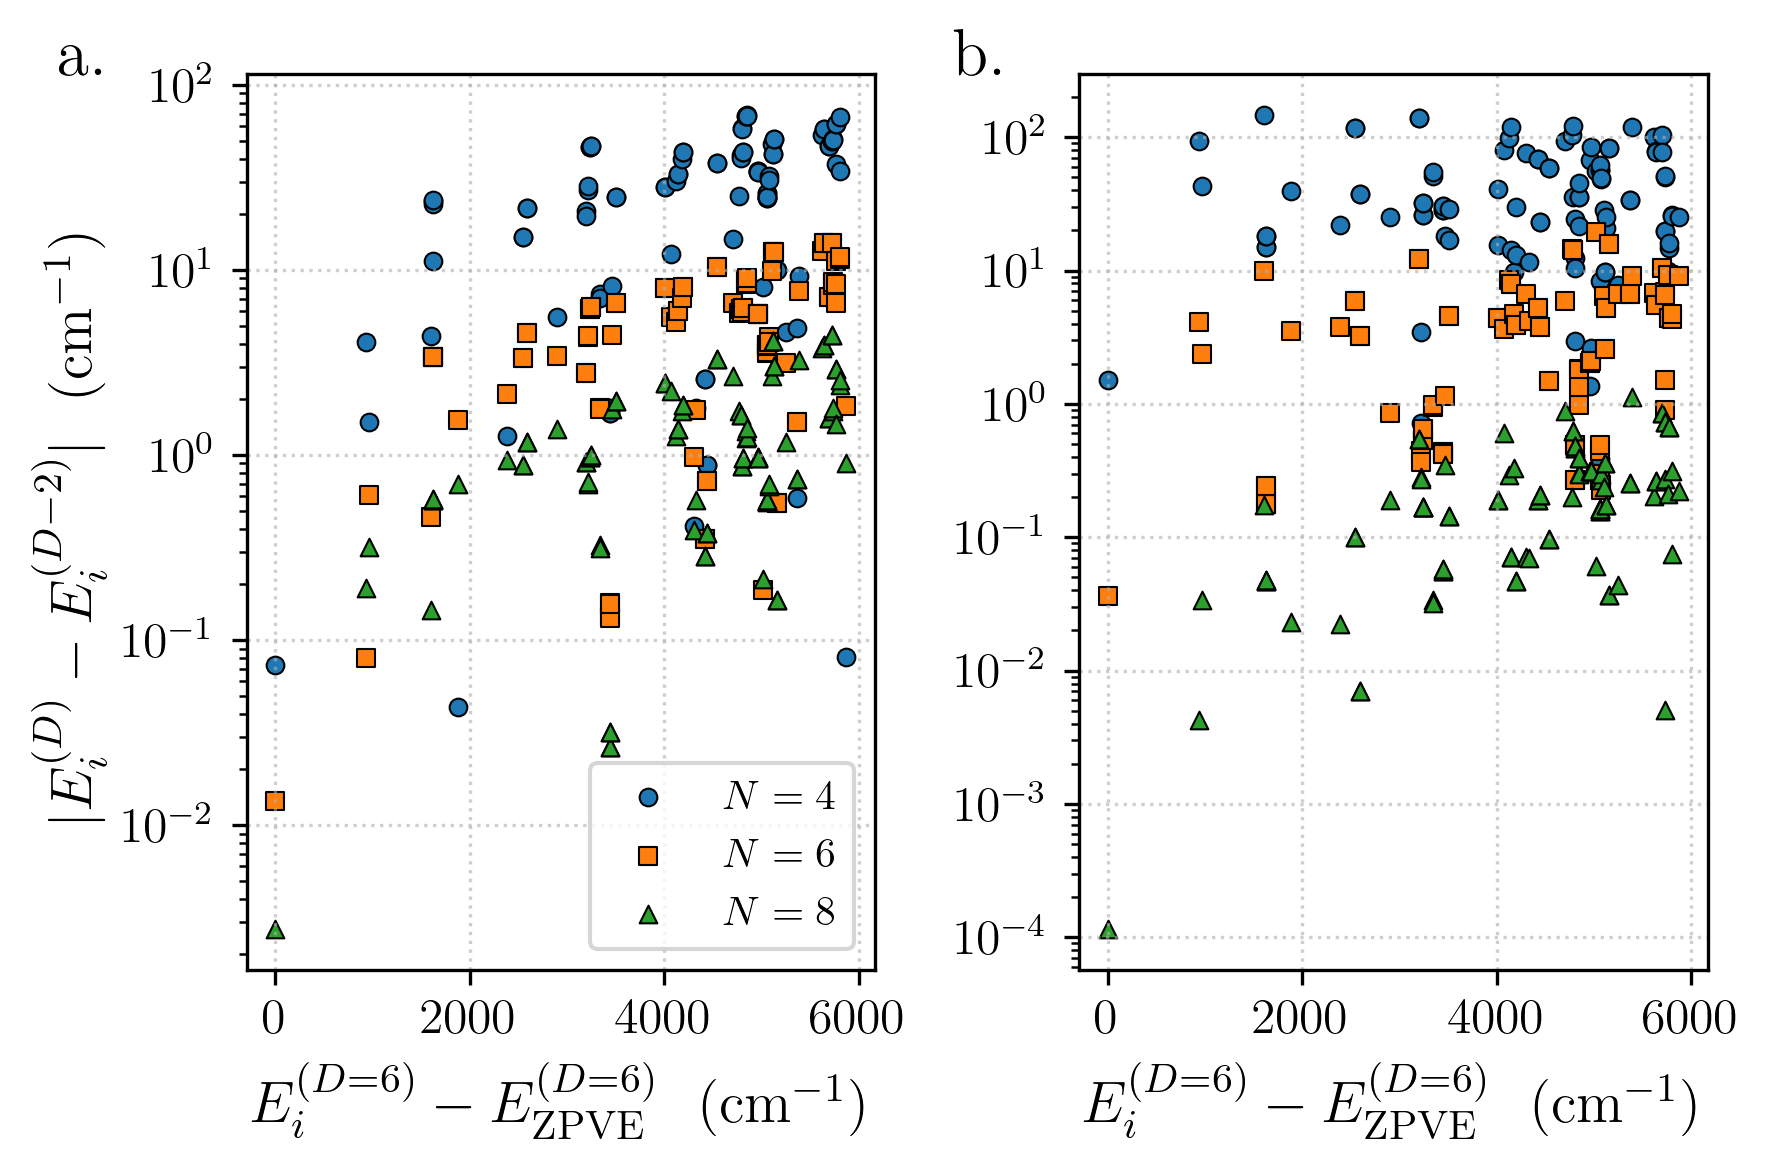

In [28]:
data = np.load("_nh3_pow_enr.npz")
enr = {eval(key): data[key] for key in data.files}

de_gmat = np.array(
    [np.abs(enr[(n, 8, n)] - enr[(n - 2, 8, n - 2)]) for n in range(4, 9, 2)]
)
de_poten = np.array(
    [np.abs(enr[(8, n, 8)] - enr[(8, n - 2, 8)]) for n in range(4, 9, 2)]
)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=300)

for i, (ax, de) in enumerate(zip(axes, (de_gmat, de_poten))):
    for n, (d, marker) in enumerate(zip(de, ("o", "s", "^", "D", "v"))):
        ax.scatter(
            enr[(8, 8, 8)][1:],  # skip zpe
            d[1:],
            marker=marker,
            s=18,
            edgecolors="black",
            linewidths=0.5,
            label=f"$N={2*n+4}$",
        )

    ax.set_yscale("log")
    ax.set_xlabel(
        "$E_i^{(D=6)}-E_{\\rm ZPVE}^{(D=6)}$~~(${\\rm cm}^{-1}$)", fontsize=14
    )
    if i == 0:
        ax.set_ylabel("$|E_i^{(D)}-E_i^{(D-2)}|$~~(${\\rm cm}^{-1})$", fontsize=14)
        ax.legend(
            fontsize=10,
            ncol=1,
            loc="best",
            # loc="center",
            # bbox_to_anchor=(0.5, 0.3),
        )
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=12)

# Add panel labels
axes[0].text(
    -0.3,
    1.05,
    "a.",
    transform=axes[0].transAxes,
    fontsize=16,
    va="top",
    ha="left",
)

axes[1].text(
    -0.2,
    1.05,
    "b.",
    transform=axes[1].transAxes,
    fontsize=16,
    va="top",
    ha="left",
)
plt.tight_layout()
fig.savefig(f"_nh3_pow_enr.pdf", format="pdf", bbox_inches="tight")